# 1.1 Feature Selection

- 1.1.0 Feature Scaling
- 1.1.1 Factor Analysis
- 1.1.2 Mutual Information
- 1.1.3 Decision Trees

Code hiding script from [Damian Kao](http://blog.nextgenetics.net/?e=102).

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Code hidden for easier reading: <a href="javascript:code_toggle()">toggle on/off.</a>''')

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from research.strings import TARGET, PREDICTORS, INSPECTORS, OTHER_PREDICTORS
from research.evaluation import evaluate_model, show_roc
from research.metrics import show_metrics, compare_metrics, to_inspection_daynum

Load train/test data. Recall the date ranges (inclusive):

- Training Data: Sept 2011 - Apr 2014
- Test Data: Sept 2014 - Oct 2014

In [3]:
d_train = pd.read_csv("data/train_data.csv")
d_test = pd.read_csv("data/test_data.csv")
X_train = d_train[PREDICTORS]
X_test = d_test[PREDICTORS]
y_train = d_train[TARGET]
y_test = d_test[TARGET]
print("Train: N = {0}, P(CriticalFound|X) = {1:.3f}".format(len(X_train), y_train.mean()))
print("Test:  N = {0}, P(CriticalFound|X) = {1:.3f}".format(len(X_test), y_test.mean()))

Train: N = 17075, P(CriticalFound|X) = 0.141
Test:  N = 1637, P(CriticalFound|X) = 0.158


Load the logistic regression model used by the City. This confusion matrix serves as a baseline for comparison to other models.

**Note:** Unless stated otherwise, all models are fitted to the training data and evaluated on the test data.

**Table 1.** Confusion matrix for the logistic regression model used by the City.

In [4]:
print("Logistic Regression")
print("------------------")
clf = pickle.load(open("models/sklearn-glm.pkl", "rb"))
evaluate_model(y_test, clf.predict(X_test))

Logistic Regression
------------------
F1 Score = 0.08664
Precision = 0.63158
Recall = 0.04651


,Predicted +,Predicted -
Actual +,12,246
Actual -,7,1372


AUROC = 0.672


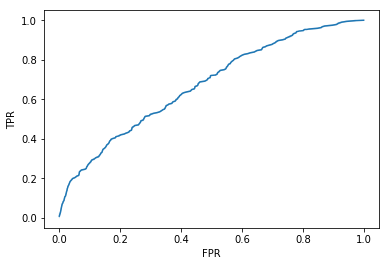

In [5]:
show_roc(clf, X_test, y_test)

## 1.1.0 Feature Scaling

Figure 1 shows the scatter plot matrix. Hue indicates whether or not a critical violation was found (blue: none, red: at least one). This figure is not very helpful for binary features, so it only includes the relationships among the continuous features.

**Note:** In theory, `ageAtInspection` should be a continuous feature, but in this dataset, it appears to only have two distinct values.

**Figure 1.** Scatter plot matrix for the continuous features, with hue for the target variable.

In [6]:
features_cont = [
    "timeSinceLast",
    "temperatureMax",
    "heat_burglary",
    "heat_sanitation",
    "heat_garbage"
]
other_binary = [
    "ageAtInspection",
    "pastSerious",
    "pastCritical",
    "consumption_on_premises_incidental_activity",
    "tobacco_retail_over_counter"
]
features_binary = INSPECTORS + other_binary

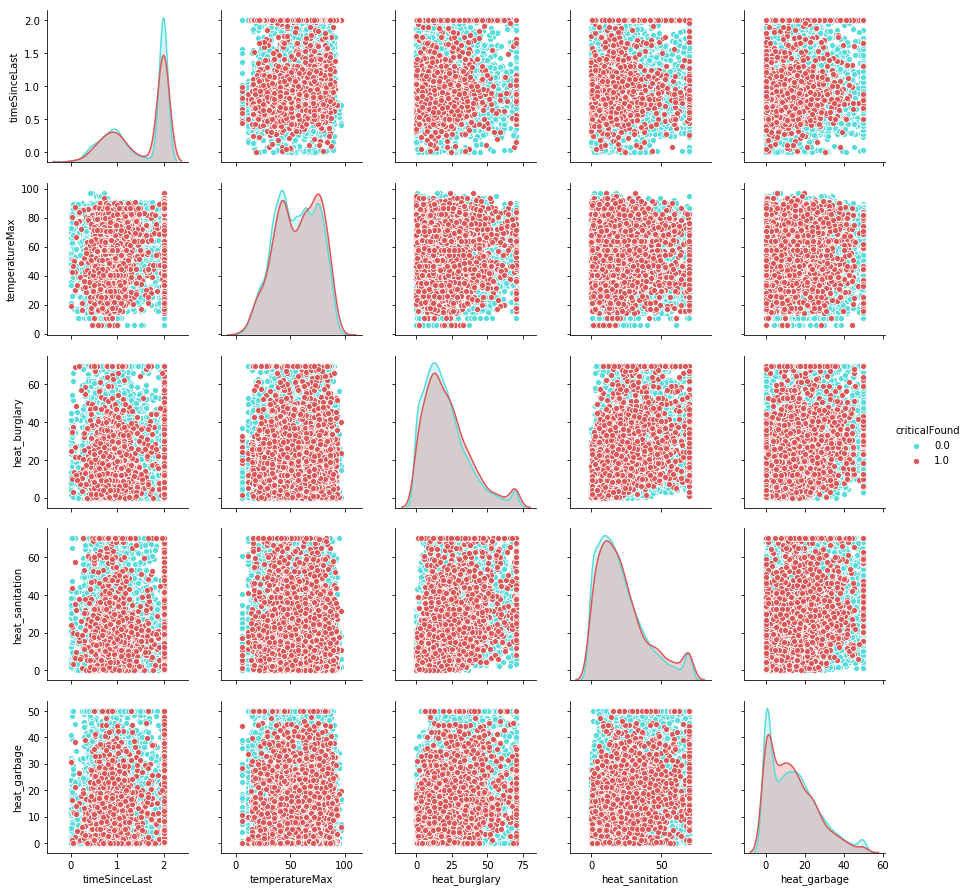

In [7]:
sns.pairplot(
    data=d_train, vars=features_cont, hue=TARGET,
    diag_kind="kde", palette=sns.hls_palette(2, h=0.5)
)
plt.show()

The scatterplot matrix does not show any clear relationships between the continuous predictor variables.

I use `StandardScaler` from scikit-learn to z-score each continuous feature.

Scaling the continuous features (not including `ageAtInspection`) improves recall at the cost of precision, with a much better overall F1-score. However, AUC is worse compared to the City model.

In [8]:
from sklearn.preprocessing import StandardScaler

def scale_cont_features(X_orig, cont_features):
    X = pd.DataFrame(X_orig.copy())
    for feat in cont_features:
        scaler = StandardScaler()
        X[feat] = scaler.fit_transform(X[feat].values.reshape(-1, 1))
    return X

In [9]:
from sklearn.linear_model import LogisticRegression

print("Logistic Regression (Scaled Continuous Features)")
print("------------------")
X_train_scaled = scale_cont_features(X_train, features_cont)
X_test_scaled = scale_cont_features(X_test, features_cont)
logit_scaled = LogisticRegression(solver="saga", fit_intercept=True, class_weight="balanced")
logit_scaled.fit(X_train_scaled, y_train)
evaluate_model(y_test, logit_scaled.predict(X_test_scaled))

Logistic Regression (Scaled Continuous Features)
------------------
F1 Score = 0.32959
Precision = 0.21728
Recall = 0.68217


,Predicted +,Predicted -
Actual +,176,82
Actual -,634,745


AUROC = 0.623


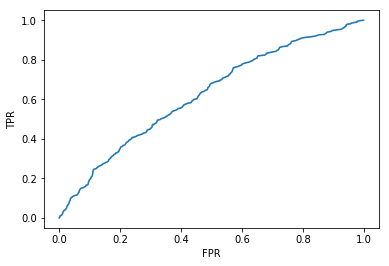

In [10]:
show_roc(logit_scaled, X_test, y_test)

As expected, this scaling leads to changes in model coefficients. Percent change shows the difference as a percentage of the original coefficient.

In [11]:
coef_df = pd.DataFrame({
    "City Model": clf.coef_[0].flatten(),
    "Scaled Model": logit_scaled.coef_[0]
}, PREDICTORS)
coef_df["Percent Change"] = 100 * ((coef_df["Scaled Model"] - coef_df["City Model"]) / coef_df["City Model"])
coef_df["Sign Change"] = np.sign(coef_df["Scaled Model"]) != np.sign(coef_df["City Model"])
coef_df.round(3)

,City Model,Scaled Model,Percent Change,Sign Change
Inspector_blue,0.950,0.949,-0.060,False
Inspector_brown,-1.306,-1.632,24.925,False
Inspector_green,-0.244,-0.293,20.128,False
Inspector_orange,0.202,0.178,-11.871,False
Inspector_purple,1.555,1.572,1.116,False
Inspector_yellow,-0.697,-0.794,13.978,False
pastSerious,0.302,0.311,3.018,False
pastCritical,0.427,0.421,-1.599,False
timeSinceLast,0.097,0.059,-38.741,False
ageAtInspection,-0.164,-0.182,10.801,False


Ultimately, scaling the continuous features does not seem to improve the metrics the city cares about.

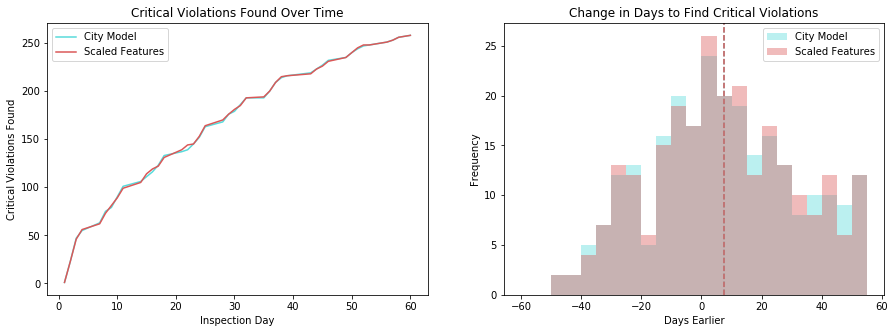

,Model,First Half,Mean Change,Std. Change
1,Scaled Features,0.69,7.457,24.677
0,City Model,0.69,7.438,25.156


In [12]:
days = to_inspection_daynum(d_test["Inspection_Date"])
compare_metrics(y_test, days, [
    ("City Model", clf.predict_proba(X_test)[:,1]),
    ("Scaled Features", logit_scaled.predict_proba(X_test_scaled)[:,1])
])

## 1.1.1 Factor Analysis

The goal of factor analysis is to resolve multicollinearity issues between the predictors.

To choose the number of composite features from factor analysis, figure 2 show the proportion of variance explained as the number of factors grows. It takes five factors to account for all variance. I referenced [this StackOverflow post](https://stackoverflow.com/questions/41388997/factor-analysis-in-sklearn-explained-variance) for the code to calculate explained variance.

**Figure 2.** Proportion of variance explained by factors.

In [13]:
from sklearn.decomposition import FactorAnalysis

def fa_var_explained(fa):
    m = fa.components_
    n = fa.noise_variance_
    m1 = m**2
    m2 = np.sum(m1,axis=1)
    var_explained = m2 / (np.sum(m2) + np.sum(n))
    return var_explained

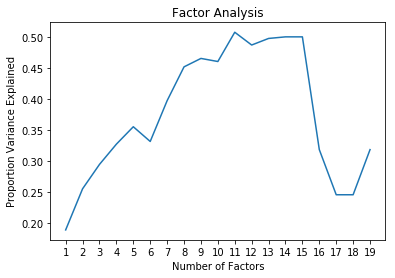

In [14]:
nc_vals = list(range(1, 20))
var_exp = np.zeros(len(nc_vals))
for i, nc in enumerate(nc_vals):
    fa = FactorAnalysis(n_components=nc, random_state=0, max_iter=10000)
    fa.fit(X_train_scaled)
    var_exp[i] = fa_var_explained(fa).sum()
sns.lineplot(x=nc_vals, y=var_exp)
plt.xticks(nc_vals)
plt.xlabel("Number of Factors")
plt.ylabel("Proportion Variance Explained")
plt.title("Factor Analysis")
plt.show()

Figure 3 shows how each of the original features contributes to the factors.

**Help:** The loading matrix weights seem to be influenced by the scale of values. Should the continuous features be scaled before factor analysis? If so, what kind of scaling? What is the appropriate way to treat binary variables for factor analysis?

**Figure 3.** Loading matrix values for each composite feature.

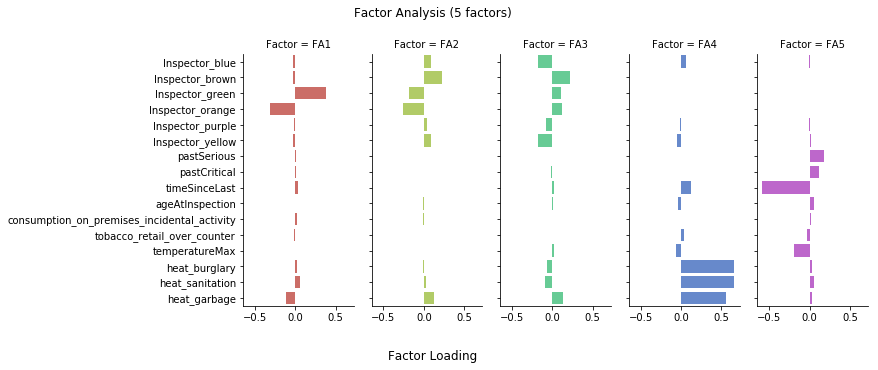

In [15]:
n_factors = 5
fa = FactorAnalysis(n_components=n_factors, random_state=0, max_iter=10000)
fa.fit(X_train_scaled)
factor_names = ["FA{}".format(i + 1) for i in range(n_factors)]
loading_vals = []
for i, factor in enumerate(factor_names):
    for j, pred in enumerate(PREDICTORS):
        loading_vals.append((factor, pred, fa.components_[i][j]))
fa_df = pd.DataFrame(loading_vals, columns=["Factor", "Feature", "Weight"])
g = sns.FacetGrid(
    fa_df, col="Factor", height=5, aspect=0.5,
    hue="Factor", palette="hls"
)
g.map(sns.barplot, "Weight", "Feature", order=PREDICTORS)
plt.subplots_adjust(top=0.85, bottom=0.15)
g.set_axis_labels(x_var="", y_var="")
g.fig.suptitle("Factor Analysis ({} factors)".format(n_factors))
g.fig.text(0.5, 0, "Factor Loading", ha="center", fontsize=12)
plt.show()

**Figure 4.** Inspections plotted according to the first two composite features, with hue for the target variable.

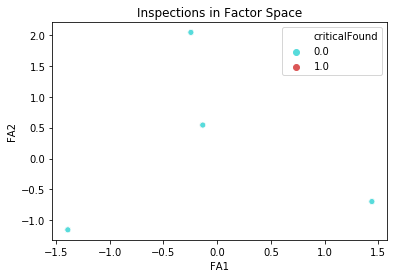

In [16]:
fa_transformer = FactorAnalysis(n_components=n_factors, random_state=0, max_iter=10000)
fa_transformer.fit(X_train_scaled)
X_train_fa = fa_transformer.transform(X_train_scaled)
X_test_fa = fa_transformer.transform(X_test_scaled)
d_fa = pd.DataFrame(X_train_fa, columns=factor_names)
sns.scatterplot(x="FA1", y="FA2", data=d_fa, hue=y_train, palette=sns.hls_palette(2, h=0.5))
plt.title("Inspections in Factor Space")
plt.show()

**Figure 5.** Evaluation scores for logistic regression using different numbers of composite features.

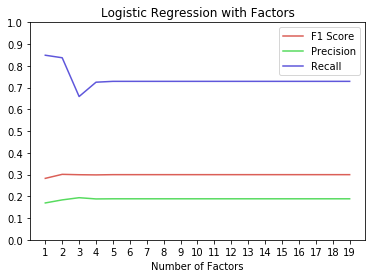

In [17]:
score_list = []
for u in nc_vals:
    reg = LogisticRegression(solver="saga", fit_intercept=True, class_weight="balanced")
    reg.fit(X_train_fa[:,:u], y_train)
    f1, pr, rc, _, _ = evaluate_model(y_test, reg.predict(X_test_fa[:,:u]), verbose=False)
    score_list.append((u, f1, pr, rc))
scores = np.array(score_list)
pal = sns.hls_palette(3)
sns.lineplot(x=scores[:,0], y=scores[:,1], label="F1 Score", color=pal[0])
sns.lineplot(x=scores[:,0], y=scores[:,2], label="Precision", color=pal[1])
sns.lineplot(x=scores[:,0], y=scores[:,3], label="Recall", color=pal[2])
plt.xticks(nc_vals)
plt.xlabel("Number of Factors")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Logistic Regression with Factors")
plt.show()

Based on figure 5, it seems best to use the first two composite features. F1 score and precission stay roughly the same, but recall starts to drop after two factors.

**Table 2.** Confusion matrix for logistic regression using two composite features from factor analysis.

In [18]:
uf = 2
logres = LogisticRegression(solver="saga", fit_intercept=True, class_weight="balanced")
logres.fit(X_train_fa[:,:uf], y_train)
evaluate_model(y_test, logres.predict(X_test_fa[:,:uf]))

F1 Score = 0.30105
Precision = 0.18352
Recall = 0.83721


,Predicted +,Predicted -
Actual +,216,42
Actual -,961,418


Comparing table 1 and table 2, using the composite features improves F1 score and recall at the expense of precision.

## 1.1.2 Mutual Information

Mutual information measures how much each predictor variable reduces entropy in the target variable.

**Figure 6.** Mutual information scores between each predictor and finding a critical violation.

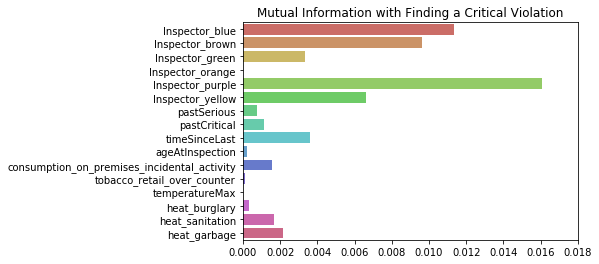

In [19]:
from sklearn.feature_selection import mutual_info_classif

discrete_idx = [PREDICTORS.index(d) for d in features_binary]
mi = mutual_info_classif(X_train, y_train, discrete_features=discrete_idx, random_state=0)
ax = sns.barplot(x=mi, y=PREDICTORS, palette="hls")
plt.xticks(np.arange(0, 0.02, 0.002))
plt.title("Mutual Information with Finding a Critical Violation")
plt.show()

The six inspector cluster variables have the highest mutual information with the target variable.

Recall the relative order of each inspector cluster according to their hit rate, shown in table 3.

**Table 3.** Inspector clusters ordered by hit rate for finding critical violations. `Count` indicates the number of inspections each cluster of sanitarians conducted in the training set. `Coefficient` shows the coefficient for that cluster in the model used by City.

In [20]:
df_ins = pd.DataFrame(d_train)
df_ins["Inspector"] = df_ins[INSPECTORS].idxmax(axis=1).apply(lambda x: str(x)[10:])
ins_sum = pd.DataFrame(
    clf.coef_[0][:,0][0:len(INSPECTORS)],
    INSPECTORS, columns=["Coefficient"]
)
ins_sum["Count"] = df_ins.groupby(["Inspector"]).size().values
ins_sum["Hit Rate"] = df_ins.groupby(["Inspector"])[TARGET].mean().values
ins_sum[["Hit Rate", "Count", "Coefficient"]].round(3).sort_values(by="Coefficient", ascending=False)

,Hit Rate,Count,Coefficient
Inspector_purple,0.406,1174,1.555
Inspector_blue,0.265,2897,0.950
Inspector_orange,0.136,3769,0.202
Inspector_green,0.095,4595,-0.244
Inspector_yellow,0.058,2762,-0.697
Inspector_brown,0.024,1878,-1.306


**Help:** How should I interpret these mutual information values?

The highest value for mutual information is below `0.018`. What is the typical scale for mutual information?

In this case, I did not treat `ageAtInspection` as a discrete variable. Based on the scatter plot matrix from figure 1, should it have been grouped with the discrete variables?

Why does the order of the inspector clusters according to mutual information not match the order according to critical violation hit rate?

I expected that `inspector_brown` would have the highest mutual information. For example, if we knew only that an inspection was conducted by a sanitarian from the brown cluster, then the proportion of passing inspections would be `1 - 0.024 = 0.976`. So, if we always guessed that an inspection conducted by cluster brown would pass, then we would be correct 97.6% of the time.

However, it makes sense that `inspector_purple` has the highest mutual information. The hit rate for sanitarians in this cluster is closest to `0.5`, which is where entropy would be maximimized.

Why does `inspector_orange` have mutual information of zero?

## 1.1.3 Decision Trees

The goal of building decision trees for this task is to analyze how useful each feature is for splitting the data.

Gini importance measures the average decrease in entropy due to each feature.

**Figure 7.** Gini importance for each feature when fitting a decision tree with no stopping condition.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from research.evaluation import visualize_tree

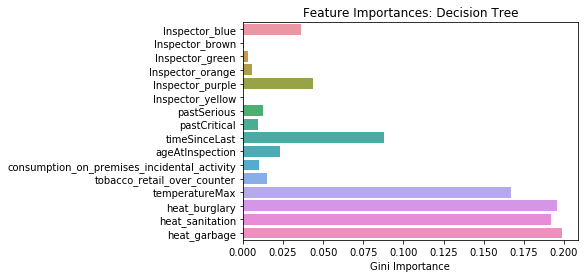

In [22]:
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
sns.barplot(x=tree.feature_importances_, y=PREDICTORS)
plt.xlabel("Gini Importance")
plt.title("Feature Importances: Decision Tree")
plt.show()

**Help:** How should I interpret the feature importance scores?

Why do the inspector variables have lower Gini importance compared to `temperatureMax`, `head_burglary`, `heat_sanitation`, and `heat_garbage`?

**Table 4.** Confusion matrix for decision tree using all predictors and no stopping condition.

In [23]:
print("Decision Tree (All Features)")
print("------------------")
evaluate_model(y_test, tree.predict(X_test))

Decision Tree (All Features)
------------------
F1 Score = 0.18589
Precision = 0.16718
Recall = 0.20930


,Predicted +,Predicted -
Actual +,54,204
Actual -,269,1110


**Table 5.** Confusion matrix for decision tree excluding inspector features and using no stopping condition.

In [24]:
print("Decision Tree (No Inspectors)")
print("------------------")
dt_no_ins = DecisionTreeClassifier()
dt_no_ins.fit(X_train[OTHER_PREDICTORS], y_train)
evaluate_model(y_test, dt_no_ins.predict(X_test[OTHER_PREDICTORS]))

Decision Tree (No Inspectors)
------------------
F1 Score = 0.17423
Precision = 0.16382
Recall = 0.18605


,Predicted +,Predicted -
Actual +,48,210
Actual -,245,1134


In [25]:
feature_sets = [
    (PREDICTORS, "All Features"),
    (OTHER_PREDICTORS, "No Inspectors")
]

def plot_tree_scores(feats, attr, attr_range, params={}, ax=None):
    score_list = []
    for val in attr_range:
        kws = dict(params)
        kws[attr] = val
        dt = DecisionTreeClassifier(**kws)
        dt.fit(X_train[feats], y_train)
        f1, pr, rc, _, _ = evaluate_model(y_test, dt.predict(X_test[feats]), verbose=False)
        score_list.append((val, f1, pr, rc))
    scores = np.array(score_list)
    pal = sns.hls_palette(3)
    sns.lineplot(x=scores[:,0], y=scores[:,1], label="F1 Score", color=pal[0], ax=ax)
    sns.lineplot(x=scores[:,0], y=scores[:,2], label="Precision", color=pal[1], ax=ax)
    sns.lineplot(x=scores[:,0], y=scores[:,3], label="Recall", color=pal[2], ax=ax)

Comparing tables 4 and 5 to table 1 (City model), both decision trees show higher scores for F1 and recall and lower scores for precision. Comparing tables 4 and 5 to table 2 (logistic regression with factor analysis), both decision trees have higher scores for precision but lower scores for F1 and recall.

Comparing table 4 to table 5, the decision tree that excludes the inspector variables appears to have higher precision and equivalent recall, leading to a higher overall F1 score.

Figures 8 through 11 show the evaluation metrics for varying the decision tree stopping conditions.

**Figure 8.** Evaluation metrics for decision trees with varying maximum depth. Inclusive range: min=1, max=50, step=1. Scores appear to stay level for depth values above 50, up to `max_depth=500`.

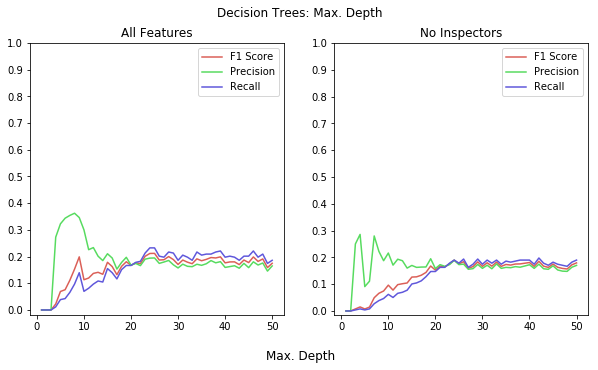

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for ax, (feats, title) in zip(axes, feature_sets):
    plot_tree_scores(feats, "max_depth", range(1, 51, 1), ax=ax)
    ax.set_xticks(range(0, 55, 10))
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_title(title)
fig.text(0.5, 0, "Max. Depth", ha="center", fontsize=12)
fig.suptitle("Decision Trees: Max. Depth")
plt.show()

**Figure 9.** Evaluation metrics for decision trees with varying number of minimum samples to be a leaf node. Inclusive range: min=10, max=200, step=10.

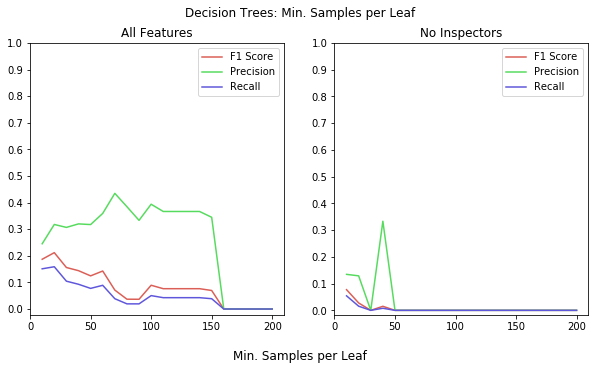

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for ax, (feats, title) in zip(axes, feature_sets):
    plot_tree_scores(feats, "min_samples_leaf", range(10, 205, 10), ax=ax)
    ax.set_xticks(range(0, 205, 50))
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_title(title)
fig.text(0.5, 0, "Min. Samples per Leaf", ha="center", fontsize=12)
fig.suptitle("Decision Trees: Min. Samples per Leaf")
plt.show()

**Figure 10.** Evaluation metrics for decision trees with varying number of maximum leaf nodes. Leaf nodes chosen by order of relative information gain. Inclusive range: min=10, max=500, step=10.

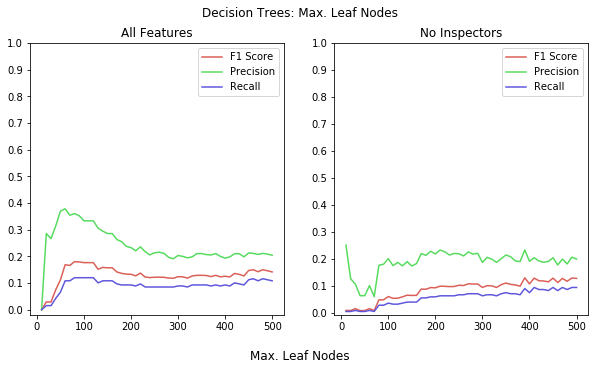

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for ax, (feats, title) in zip(axes, feature_sets):
    plot_tree_scores(feats, "max_leaf_nodes", range(10, 505, 10), ax=ax)
    ax.set_xticks(range(0, 505, 100))
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_title(title)
fig.text(0.5, 0, "Max. Leaf Nodes", ha="center", fontsize=12)
fig.suptitle("Decision Trees: Max. Leaf Nodes")
plt.show()

**Figure 11.** Evaluation metrics for decision trees with thresholds of minimum impurity decrease needed to make a split. Inclusive range: min=0, max=0.05, step=0.0001. Scores appear to stay level for values above 0.05, up to `min_impurity_decrease=0.5`.

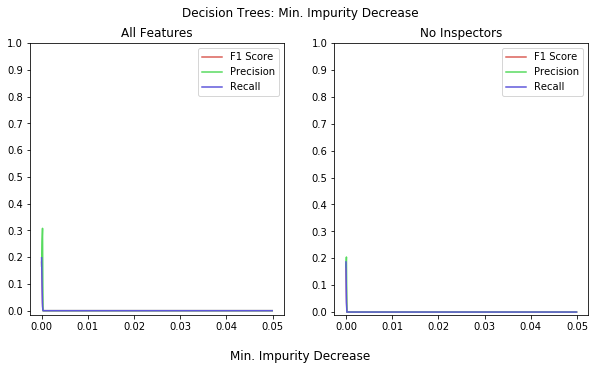

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for ax, (feats, title) in zip(axes, feature_sets):
    plot_tree_scores(feats, "min_impurity_decrease", np.arange(0, 0.05, 0.0001), ax=ax)
    ax.set_xticks(np.arange(0, 0.06, 0.01))
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_title(title)
fig.text(0.5, 0, "Min. Impurity Decrease", ha="center", fontsize=12)
fig.suptitle("Decision Trees: Min. Impurity Decrease")
plt.show()

**Help:** Why do higher thresholds for minimum impurity decrease appear not to improve performance?

Some features had Gini importance near `0.18`, are those influenced by splits further down in the tree?

To visualize a sample decision tree, I chose `max_depth=7` somewhat arbitarily. The tree is quite big, so at greater depths, it becomes harder to read the diagram. Producing the diagram is time-intensive, so a copy can be found in `figures/tree_height_7.png`.

**Table 6.** Confusion matrix for decision tree with maximum depth of 7.

In [30]:
tree_depth = 7
print("Decision Tree (depth = {})".format(tree_depth))
print("------------------")
tree_lim = DecisionTreeClassifier(max_depth=tree_depth, random_state=0)
tree_lim.fit(X_train, y_train)
evaluate_model(y_test, tree_lim.predict(X_test))

Decision Tree (depth = 7)
------------------
F1 Score = 0.11111
Precision = 0.35417
Recall = 0.06589


,Predicted +,Predicted -
Actual +,17,241
Actual -,31,1348


Decision tree visualization produced with the following code:

```
CLASSES = ["No Critical", "Critical Found"]
COLORS = ["#57D2DB", "#DB5E56"]
im = visualize_tree(tree_lim, PREDICTORS, CLASSES, COLORS)
imfile = "figures/tree_height_{}.png".format(tree_depth)
with open(imfile, "wb") as file:
    file.write(im.data)
im
```

To visualize decision tree in the notebook, run with:

```
jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000
```

![Decision Tree, Depth = 7](figures/tree_height_7.png)

In [31]:
best_msl = 20
tree_msl = DecisionTreeClassifier(min_samples_leaf=best_msl, random_state=0)
tree_msl.fit(X_train, y_train)
evaluate_model(y_test, tree_msl.predict(X_test))

F1 Score = 0.19843
Precision = 0.30400
Recall = 0.14729


,Predicted +,Predicted -
Actual +,38,220
Actual -,87,1292


AUROC = 0.611


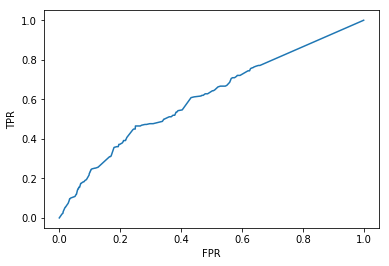

In [32]:
show_roc(tree_msl, X_test, y_test)

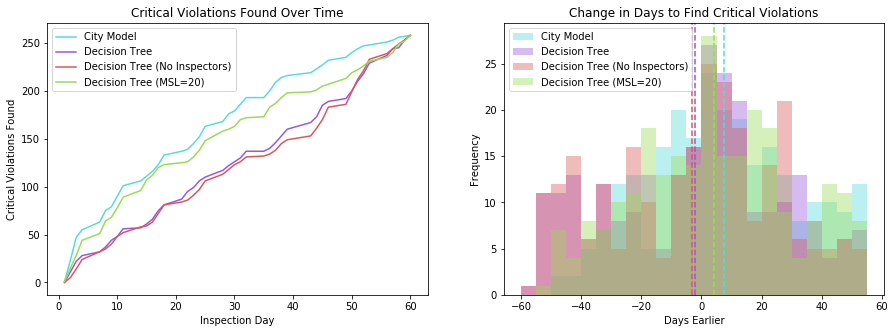

,Model,First Half,Mean Change,Std. Change
0,City Model,0.690,7.438,25.156
3,Decision Tree (MSL=20),0.624,4.023,26.127
1,Decision Tree,0.481,-2.089,28.639
2,Decision Tree (No Inspectors),0.461,-3.016,28.446


In [33]:
compare_metrics(y_test, days, [
    ("City Model", clf.predict_proba(X_test)[:,1]),
    ("Decision Tree", tree.predict_proba(X_test)[:,1]),
    ("Decision Tree (No Inspectors)", dt_no_ins.predict_proba(X_test[OTHER_PREDICTORS])[:,1]),
    ("Decision Tree (MSL=20)", tree_msl.predict_proba(X_test)[:,1])
])

In [34]:
CLASSES = ["No Critical", "Critical Found"]
COLORS = ["#57D2DB", "#DB5E56"]
im = visualize_tree(tree_msl, PREDICTORS, CLASSES, COLORS)
imfile = "figures/tree_msl_{}.png".format(best_msl)
with open(imfile, "wb") as file:
    file.write(im.data)
print("Wrote tree diagram to: {}".format(imfile))

Wrote tree diagram to: figures/tree_msl_20.png
